# Finalized Data Preprocessing and Model Creation

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\mboyk\miniconda3\python.exe -m pip install --upgrade pip


## Data Preprocessing

In [2]:
# All the imports that are needed for the models
import keras
import keras_tuner
import sklearn
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from keras.layers import Dense
from keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from keras.optimizers import SGD
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression, LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures

In [3]:
# This is our index of different timezone and major cities within each timezone in the form of a dictionary
cities_by_timezone = {
    'Pacific Time': ['Los Angeles', 'San Francisco Bay Area', 'Seattle', 'Portland', 'San Luis Obispo', 'Sacramento', 'San Diego', 'Santa Barbara', 'Camarillo', 'Fremont', 'Bend', 'Reno', 'Spokane', 'Las Vegas', 'Fresno'],
    'Mountain Time': ['Denver', 'Boulder', 'Salt Lake City', 'Missoula', 'Santa Fe', 'Phoenix', 'Lehi', 'Logan', 'Boise'],
    'Central Time': ['Austin', 'Chicago', 'Minneapolis', 'Milwaukee', 'Nashville', 'Dallas', 'Cincinnati', 'Columbus', 'Indianapolis', 'Nebraska City', 'Kansas City'],
    'Eastern Time': ['New York City', 'Boston', 'Atlanta', 'Ann Arbor', 'Miami', 'Detroit', 'Stamford', 'Washington DC', 'Philadelphia', 'Raleigh', 'Walnut', 'Madison', 'Dover', 'Burlington', 'Wilmington', 'Nashua', 'Baltimore', 'Tampa Bay']
}

def date_to_index(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    for i in range(len(date_col_stock_data)):
        if date_col_stock_data[i] == date:
            return i
    return -1

def get_closest_available_date(stock_data, date):
    '''
    Get the closest available date 
    '''
    date_col_stock_data = stock_data.index.to_pydatetime()
    # date_col_stock_data = stock_data.reset_index()['Date']
    while date not in date_col_stock_data:
        date = date - timedelta(days = 1)
    return date


def weekly_price_diff(stock_data, week_end, period: int = 7):
    '''
    Finds the weekly price difference in NDXT index price in percents during last week before layoff date.

    @type stock_data: pandas DataFrame
    @param stock_data: original stock_data df
    @type week_end: datetime object
    @param week_end: layoff date in format datetime(YYYY,MM,DD)
    @type period: int
    @param period: number of days to look back, defaults to 7

    @returns price_diff: % of change in NDXT index price during last week before layoff date 
    '''
    if (week_end < datetime(2020, 1, 15)):
        return 0
    date_col_stock_data = stock_data.reset_index() 
    date_end_closest = get_closest_available_date(stock_data, week_end)
    date_start_closest = get_closest_available_date(stock_data, week_end - timedelta(days = period))
    price_start, price_end = stock_data['Open'][date_start_closest], stock_data['Open'][date_end_closest]
    price_diff = (price_end - price_start) / price_start * 100
    return price_diff

def str_to_datetime(dt_string):
    '''
    Converts a string to a formatted datetime representation of the date.

    @type dt_string: string
    @param dt_string: string to convert into a datetime object

    @returns datetime.strptime(dt_string, "%Y-%m-%d %H:%M:%S UTC"): datetime object that formats a date in a specific way
    '''
    return datetime.strptime(dt_string, "%Y-%m-%d %H:%M:%S UTC")

def get_timezone(city):
    '''
    Retrieve the timezone associated with a city.

    @type city: string
    @param city: name of city to retrieve timezone for
    @rtype: string, None
    @returns timezone: timezone of a city if in an index; otherwise, None
    '''
    for timezone, cities in cities_by_timezone.items():
        if city in cities:
            return timezone
    return None

c:\Users\mboyk\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


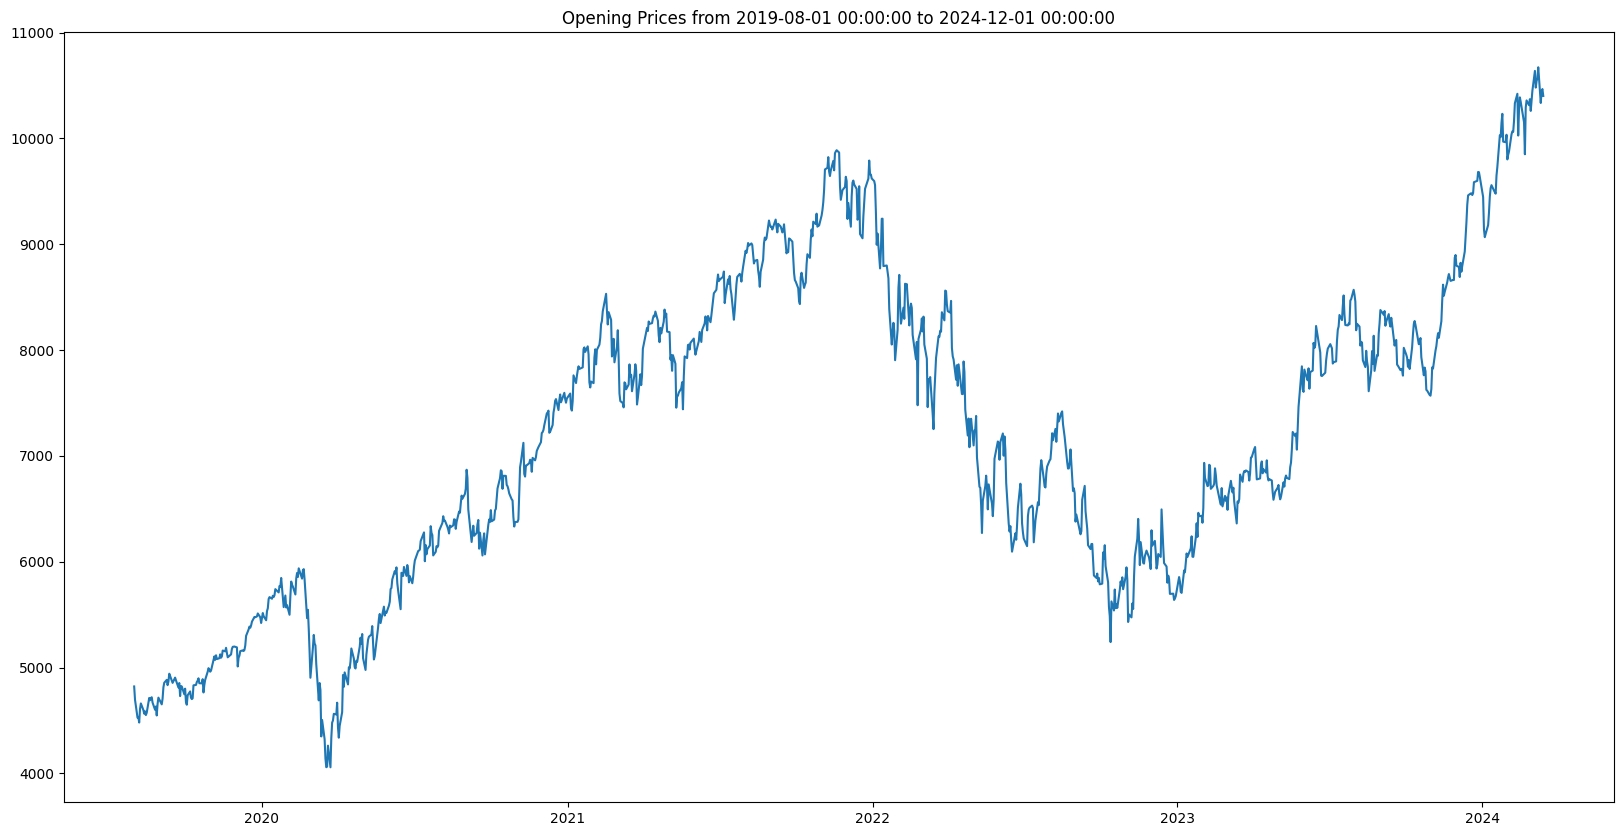

In [4]:
# Read in our stock data from August 1st, 2018 to December 1st, 2024
stock_data = yf.download('^NDXT', start=datetime(2019, 8, 1),
                         end=datetime(2024, 12, 1))
stock_data.to_csv('datasets/stock_data.csv', index = True, encoding='utf-8')

# Visualize our preliminary stock data of opening prices
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(datetime(2019, 8, 1),
                                                datetime(2024, 12, 1)))
plt.plot(stock_data['Open'])
plt.show()

In [5]:
week_price_diff_df = pd.DataFrame(index = stock_data.index, columns = ['price_diff'])
for date in week_price_diff_df.index:
    week_price_diff_df.loc[date, 'price_diff'] = weekly_price_diff(stock_data, date)

stock_data['price_diff'] = week_price_diff_df['price_diff']
stock_data.to_csv('datasets/stock_data.csv', index = True, encoding='utf-8')
stock_data

,Open,High,Low,Close,Adj Close,Volume,price_diff
Date,,,,,,,
2019-08-01,4821.149902,4924.919922,4726.339844,4762.810059,4762.810059,425800,0
2019-08-02,4695.549805,4712.990234,4629.250000,4655.560059,4655.560059,356000,0
2019-08-05,4525.939941,4534.649902,4434.459961,4469.970215,4469.970215,427900,0
2019-08-06,4530.689941,4562.890137,4481.229980,4531.810059,4531.810059,317500,0
2019-08-07,4480.180176,4563.459961,4470.759766,4550.560059,4550.560059,321600,0
...,...,...,...,...,...,...,...
2024-03-08,10672.330078,10724.919922,10408.530273,10415.330078,10415.330078,0,2.104794
2024-03-11,10335.139648,10387.099609,10254.669922,10359.639648,10359.639648,0,-2.848064
2024-03-12,10449.839844,10532.879883,10337.089844,10530.349609,10530.349609,0,-0.291597


In [6]:
layoff_data = pd.read_csv('datasets/tech_layoffs.csv')
layoff_data['Date_layoffs'] = layoff_data['Date_layoffs'].apply(str_to_datetime)
layoff_data['Company'] = layoff_data['Company'].replace({'SaleSan Franciscoorce': 'Salesforce'})
layoff_data.set_index('Date_layoffs', inplace = True)
layoff_data = layoff_data.sort_index()
layoff_data = layoff_data[(layoff_data['Continent'] == 'North America') & 
                          (layoff_data['Country'] == 'USA') & 
                          (layoff_data['Company_Size_before_Layoffs'] >= 10)].drop(columns=["Company", "lat", "lng", "Continent", "Country", "#"])

# Assign new attribute 'Timezone' based on city
layoff_data['Region'] = layoff_data['Location_HQ'].map(get_timezone)
layoff_data = layoff_data.drop(columns=["Location_HQ", "Company_Size_after_layoffs", "Laid_Off"]) 

#Incorporate stock price
layoff_data = layoff_data.reset_index()

#Create a new column for stock price change, and add it to the layoff_data_with_date_col dataframe
layoff_data.insert(1, "stock_delta", layoff_data["Date_layoffs"].apply(lambda x: weekly_price_diff(stock_data, x, period=90)))
# bug: several stock_delta values are 0, which is highly improbable.


industry_encoder = LabelEncoder()
layoff_data['industry_encoded'] = industry_encoder.fit_transform(layoff_data['Industry'])

time_encoder = LabelEncoder()
layoff_data['Region_encoded'] = time_encoder.fit_transform(layoff_data['Region'])

# Create LabelEncoder instance for stage column
stage_encoder = LabelEncoder()
layoff_data['stage_encoded'] = stage_encoder.fit_transform(layoff_data['Stage'])
layoff_data = layoff_data.drop(columns=["Industry", "Stage","Year","Region"])
layoff_data['Money_Raised_in_$_mil'] = layoff_data['Money_Raised_in_$_mil'].str.replace('$', '').astype(float) * 1000000

#convert date layoffs to unix
layoff_data['Date_layoffs'] = layoff_data['Date_layoffs'].apply(lambda x: int(datetime.timestamp(x)))

# Set our target to be the percentage of a company expected to be laid off at a specific point in time
Y = layoff_data['Percentage']

# Extract and encode our string data such that it makes our data preprocessing more organized
industry = layoff_data['industry_encoded'].values.reshape(-1, 1)
stage = layoff_data['stage_encoded'] .values.reshape(-1, 1)
region = layoff_data['Region_encoded'].values.reshape(-1, 1)

# One-hot encode the string data columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
industry_onehot, stage_onehot, region_onehot = encoder.fit_transform(industry), encoder.fit_transform(stage), encoder.fit_transform(region)

# Drop the original categorical columns from layoff_data
layoff_data = layoff_data.drop(columns=["industry_encoded", "stage_encoded", "Region_encoded", "Percentage"])
display(layoff_data)

# Concatenate numerical features and one-hot encoded features, and set it as X
X = np.hstack((layoff_data.values, industry_onehot, stage_onehot, region_onehot))

,Date_layoffs,stock_delta,Company_Size_before_Layoffs,Money_Raised_in_$_mil
0,1583996400,-17.938421,50,90000000.0
1,1584082800,-15.003683,80,45000000.0
2,1584342000,-19.758224,591,79000000.0
3,1584342000,-19.758224,16,6000000.0
4,1584514800,-24.824380,20,4000000.0
...,...,...,...,...
897,1704873600,14.204551,188000,26000000.0
898,1704873600,14.204551,450,57000000.0
899,1704960000,15.684460,1000,995000000.0
900,1704960000,15.684460,2000,14000000.0


In [7]:
# layoff_data.values, industry_onehot, stage_onehot, region_onehot
print("LAYOFF DATA VALS:", str(layoff_data.values[0]))
print("INDUSTRY ONEHOT:", str(industry_onehot[0]))
print("STAGE ONEHOT:", str(stage_onehot[0]))
print("REGION ONEHOT:", str(region_onehot[0]))

print("X:", str(X[0]))

LAYOFF DATA VALS: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07]
INDUSTRY ONEHOT: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0.]
STAGE ONEHOT: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
REGION ONEHOT: [0. 0. 1. 0.]
X: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.000

In [8]:
# Let's take a look at the shape of our features and our target
X.shape, Y.shape

((902, 51), (902,))

In [9]:
# Additionally, we want to use a tech layoff dataset for our predictive task of finding tech layoffs. Let's look at how it is formatted
layoff_data = pd.read_csv("datasets/tech_layoffs.csv")
layoff_data

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20 00:00:00 UTC,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19 00:00:00 UTC,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18 00:00:00 UTC,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18 00:00:00 UTC,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14 00:00:00 UTC,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,3286,Pitch,Berlin,Germany,Europe,80,2024-01-08 00:00:00 UTC,67.0,119,39,Other,Series B,$138,2024,52.52437,13.41053
1414,3287,BenchSci,Toronto,Canada,North America,70,2024-01-08 00:00:00 UTC,17.0,412,342,Healthcare,Series D,$164,2024,43.70643,-79.39864
1415,3288,NanoString Technology,Seattle,USA,North America,50,2024-01-08 00:00:00 UTC,9.0,556,506,Healthcare,Post-IPO,$826,2024,47.60621,-122.33207
1416,3289,Trigo,Tel Aviv,Israel,Asia,30,2024-01-04 00:00:00 UTC,15.0,200,170,Retail,Series C,$199,2024,32.08088,34.78057


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Training set shapes: X_train =", X_train.shape, ", Y_train =", y_train.shape)
print("Testing set shapes: X_test =", X_test.shape, ", Y_test =", y_test.shape)

Training set shapes: X_train = (721, 51) , Y_train = (721,)
Testing set shapes: X_test = (181, 51) , Y_test = (181,)


In [11]:
# Finally, let's take a look at our target!
Y

0       40.000000
1       10.000000
2       22.000000
3      100.000000
4       20.000000
          ...    
897      0.531915
898     13.333333
899     17.000000
900      5.000000
901     13.000000
Name: Percentage, Length: 902, dtype: float64

# Model 1: Basic Regression Models

For our first model, we want to determine whether or not our prediction model performs well with basic regression models. If it does, then it is a matter of choosing the correct regression model to analyze the data! If not, this means that we may need to look into more complex models, such as neural networks or decision trees.

In [11]:
mse_arr = []
linreg = LinearRegression()

X_train_df, y_train_df = pd.DataFrame(np.array(X_train)), pd.DataFrame(np.array(y_train))

linreg.fit(X_train_df, y_train_df)
yhat_train, yhat_test = linreg.predict(X_train), linreg.predict(X_test)

MSE_train, MSE_test = np.mean((y_train.values - yhat_train)**2), np.mean((y_test.values - yhat_test)**2)
mse_arr.append((MSE_train, MSE_test))
print(f"MSE_train: {MSE_train}\nMSE_test: {MSE_test}")

MSE_train: 484.8927144143591
MSE_test: 409.126023109986


As we can see, while our Linear Regression model is not awful, it can certainly be a whole lot better. Looking into another form of regression models, Polynomial Regression, we can see how our error change as we add more degrees to our polynomial model

In [12]:
for k in range(2,5):
    # Create kth degree polynomial
    polyreg = PolynomialFeatures(k)

    # Transform features to fit polynomial model
    train_features = polyreg.fit_transform(X_train_df)
    test_features = polyreg.fit_transform(X_test)

    # Create polynomial regression
    polyreg = LinearRegression()
    polyreg.fit(train_features, y_train_df)

    # Get training and testing predictions
    yhat_train = polyreg.predict(train_features)
    yhat_test = polyreg.predict(test_features)

    # Display training and testing MSEs
    MSE_train = np.mean((y_train.values - yhat_train) ** 2)
    MSE_test = np.mean((y_test.values - yhat_test) ** 2)

    mse_arr.append((MSE_train, MSE_test))
    print(f'Degree: {k}\n    MSE_train: {MSE_train}\n    MSE_test: {MSE_test}')

Degree: 2
    MSE_train: 518.1026127221376
    MSE_test: 742.9174604635629
Degree: 3
    MSE_train: 531.5243308390676
    MSE_test: 630.7097215553198
Degree: 4
    MSE_train: 455.36963657579736
    MSE_test: 879.6145750647544


If we graph our data, we can then see how jagged our error measures are for our training and testing data, and how our model may be underfitting due to the difference in complexity between the model and our data.

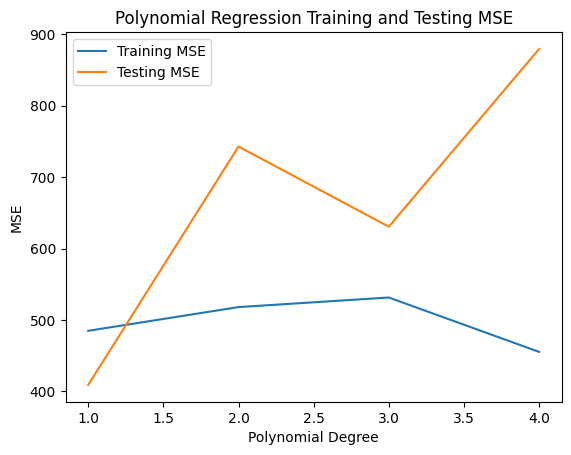

In [13]:
mse_train = [pair[0] for pair in mse_arr]
mse_test = [pair[1] for pair in mse_arr]

# Plot a graph of the training and testing MSE of the model over time
degrees = range(1, len(mse_arr) + 1)
plt.plot(degrees, mse_train, label='Training MSE')
plt.plot(degrees, mse_test, label='Testing MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Polynomial Regression Training and Testing MSE')
plt.legend()
plt.show()

Finally, we can look at a special regression model called Automatic Relevance Determination Regression. The main premise of this method is that it, similar to Linear Regression, fits a line to the data and determines feature relevance by shrinking irrelevant features.

In [18]:
ard = ARDRegression().fit(X_train, y_train_df)
yhat_train, yhat_test = ard.predict(X_train), ard.predict(X_test)

MSE_train, MSE_test = np.mean((y_train.values - yhat_train)**2), np.mean((y_test.values - yhat_test)**2)

print(f'Training Mean Squared Error: {MSE_train}\nTesting Mean Squared Error: {MSE_test}')

Training Mean Squared Error: 386.4592934222615
Testing Mean Squared Error: 290.17133207240596


C:\Users\ryand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Model 1: Analysis/Conclusion

From these models, it can be seen that while they are able to fit the data to some degree, they simply do not fit the data well enough to call it a day. Each of these models have their shortcomings when it comes to predicting training or testing data, or even both.

Thus, it would make sense that we would need a model that either illustrates the level of complexity of the model effectively or is specialized in analyzing time series data. For that, we turn to our next two models: a Neural Network and a RandomForestRegressor.

# Model 2: Neural Network

Next, we will be looking at the neural network architecture and if it may perform effectively in predicting the layoff percentages of companies. We will first try to evaluate the data with a manually created ANN, then move on towards an ANN in which the hyperparameters are modified according to the data to minimize the loss.

In [25]:
def build_nn():
    '''
    Build an Artificial Neural Network model composed of an input layer of 12 nodes with input_dim=51, an output layer of 1
    node, and 3 hidden layers of 12 nodes each, with each layer having a sigmoid activation function applied to it.

    Additionally, compile the model, setting the optimizer to be SGD with an LR of 0.1, measuring the loss with MSE and calculating
    the MSE metric.

    @type model: keras_Sequential() object
    @returns model: a built and compiled Artificial Neural Network model with the given configuration
    '''
    model = Sequential([
        Dense(12, activation='sigmoid', input_dim=51),
        Dense(12, activation='sigmoid'),
        Dense(12, activation='sigmoid'),
        Dense(12, activation='sigmoid'),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=SGD(learning_rate=0.1), loss='mse', metrics=['mse'])
    return model

def buildHPmodel(hp):
  '''
  Setup a hyperparameter model that enables us to choose the best to predict our target percentage of employees laid off at a company.

  @type hp: keras_tuner_HyperParameters object
  @param hp: the HyperParameters object that enables us to change our model's hyperparameters

  @type model: keras_Sequential() object
  @returns model: a fully configured Hyperparameter model that enables a user to modify an ANN's hyperparameters to their data
  '''
  model= Sequential([
      Dense(12, activation = 'sigmoid', input_dim = 51),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=1,activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
])
  learning_rate = hp.Float("lr", min_value=0.05, max_value=0.3, sampling="log")
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
  return model

# This is a tuner that we will be using to perform hyperparameter tuning on the second NN model that we use!
tuner = keras_tuner.GridSearch(
    hypermodel=buildHPmodel,
    objective="val_loss",
    directory="tunerStore",
    project_name="tunerInstance5",
    max_trials=50,
    seed=12,
    executions_per_trial=1,
    tune_new_entries=True,
    allow_new_entries=True,
    max_consecutive_failed_trials=3
)

Now that we have our ANN and tuner definitions set, we can perform a similar process to that of Model 1 in where we will fit the training data to the model, and see its error:

In [31]:
# Let us try out our first neural network to see how well in performs in our predictive task!
nn_regressor = KerasRegressor(model=build_nn, epochs=100, batch_size=5, verbose=0)
hist = nn_regressor.fit(X_train, y_train)
predictions_train, predictions_test = nn_regressor.predict(X_train), nn_regressor.predict(X_test)

print('Training Mean Squared Error:', mean_squared_error(predictions_train, y_train))
print('Testing Mean Squared Error:', mean_squared_error(predictions_test, y_test))

Training Mean Squared Error: 801.5509074038033
Testing Mean Squared Error: 682.485143246114


However, we can improve the model a step further through hyperparameter tuning, which is the practice of changing model hyperparameters, such as the activation functions, number of units per layer, the learning rate, and other factors associated with the neural network architecture, in order to converge to the optimal setup for the problem at hand.

We will be using the GridSearch technique taught to us within the course to search for a specific model configuration that gives us the lowest error.

In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
X_val_np = np.array(X_val)
y_val_np = np.array(y_val)

#load from tunerStore trial 48
# tuner = keras.models.load_model('tunerStore/tunerInstance3')
#why isnt this working? model = keras.models.load_model('tunerStore/tunerInstance3')

"""TO RUN A NEW GRID SEARCH UNCOMMENT THE LINE BELOW"""
tuner.search(X_train_np, y_train_np, epochs=10, validation_data=(X_val_np, y_val_np), batch_size=15)
# tuner.save('tunerStore/tunerInstance3')

Trial 50 Complete [00h 00m 06s]
val_loss: 235.16546630859375

Best val_loss So Far: 220.14390563964844
Total elapsed time: 00h 04m 54s


In [28]:
# Now, let's see how many units, types of activations, and learning rate performs best!
tuner.results_summary()

Results summary
Results in tunerStore\tunerInstance5
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 13 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.0936101501762388
Score: 220.14390563964844

Trial 47 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.07825422900366437
Score: 226.53050231933594

Trial 44 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.05
Score: 228.0859375

Trial 20 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.2742923480285484
Score: 228.7980499267578

Trial 11 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.05
Score: 231.3817138671875

Trial 49 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.13395323057981742
Score: 235.16546630859375

Trial 17 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.1602390336065017
Score: 235.59889221191406

Trial 48 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.06541731153543581
Score: 240.52723693847656

Trial 12 summary
Hyperparameters:
units1: 3
actty

In [29]:
# Now, let us look at the configuration of the best model that we have!
models = tuner.get_best_models(num_models=3)
models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                624       
                                                                 
 dense_1 (Dense)             (None, 3)                 39        
                                                                 
 dense_2 (Dense)             (None, 3)                 12        
                                                                 
 dense_3 (Dense)             (None, 3)                 12        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 691 (2.70 KB)
Trainable params: 691 (2.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
print("For our best model (Trial 13): \n")
print("The MSE for the training data: ", mean_squared_error(y_train, models[0].predict(X_train)))
print("The MSE for the testing data: ", mean_squared_error(y_test, models[0].predict(X_test)))
print("The MSE for the validation data: ", mean_squared_error(y_val, models[0].predict(X_val_np)))
print("\n")
print("For our second best model (Trial 47): \n")
print("The MSE for the training data: ", mean_squared_error(y_train, models[1].predict(X_train)))
print("The MSE for the testing data: ", mean_squared_error(y_test, models[1].predict(X_test)))
print("The MSE for the validation data: ", mean_squared_error(y_val, models[1].predict(X_val_np)))
print("\n")
print("For our third best model (Trial 44): \n")
print("The MSE for the training data: ", mean_squared_error(y_train, models[2].predict(X_train)))
print("The MSE for the testing data: ", mean_squared_error(y_test, models[2].predict(X_test)))
print("The MSE for the validation data: ", mean_squared_error(y_val, models[2].predict(X_val_np)))


For our best model (Trial 13): 

20/20 [==============================] - 0s 3ms/step
The MSE for the training data:  402.8087933564796
5/5 [==============================] - 0s 2ms/step
The MSE for the testing data:  335.09143881909677
5/5 [==============================] - 0s 4ms/step
The MSE for the validation data:  220.1438920984369


For our second best model (Trial 47): 

20/20 [==============================] - 0s 4ms/step
The MSE for the training data:  404.70366308311804
5/5 [==============================] - 0s 5ms/step
The MSE for the testing data:  339.1884078101372
5/5 [==============================] - 0s 4ms/step
The MSE for the validation data:  226.5304958750832


For our third best model (Trial 44): 

20/20 [==============================] - 0s 3ms/step
The MSE for the training data:  397.4348058435213
5/5 [==============================] - 0s 4ms/step
The MSE for the testing data:  338.8793873186497
5/5 [==============================] - 0s 3ms/step
The MSE for the 

## Hyperparameter Optimization Results
Our best three trials can be seen below.
Trial 13 rendered the best predictions, with an MSE of 220.144. We can see that it found that having 3 units within each layer, using the ReLU activation function, and having a learning rate of 0.0936 was most optimal. Trial 47 and 44 coming in second and third respectively, with different model configurations with a higher error.

```Results summary
Results in tunerStore\tunerInstance5
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 13 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.0936101501762388
Score: 220.14390563964844

Trial 47 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.07825422900366437
Score: 226.53050231933594

Trial 44 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.05
Score: 228.0859375

Trial 20 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.2742923480285484
Score: 228.7980499267578

Trial 11 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.05
Score: 231.3817138671875

Trial 49 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.13395323057981742
Score: 235.16546630859375

Trial 17 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.1602390336065017
Score: 235.59889221191406

Trial 48 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.06541731153543581
Score: 240.52723693847656

Trial 12 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.11197938216997383
Score: 245.84762573242188

Trial 15 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.06541731153543581
Score: 252.85423278808594
```

## K-Fold Cross Validation: Combatting Overfitting/Underfitting
Based on the results of the best model's MSE: the MSE for the training data:  407.6795840293022, the MSE for the testing data:  344.07788384916205, and the MSE for the validation data:  222.8351758414751. We can conclude that the model is not overfitting since the MSE for the training data is not lower than the testing data.

In [80]:
# Define the KFold parameters
kfold = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)

# Lists to store MSE scores for each fold
mse_per_fold_training, mse_per_fold_test = list(), list()

y_train_np = y_train.values
y_test_np = y_test.values

j = 0
# KFold Cross Validation
for train, test in kfold.split(X_train, y_train_np):
    # Create and compile the model
    model = build_nn()

    # Fit the model
    estimator = KerasRegressor(model=build_nn, epochs=50, batch_size=5, verbose=0)
    results = estimator.fit(X_train[train], y_train_np[train])

    # Predict and calculate MSE
    predictions_train = results.predict(X_train[train])
    predictions_test = results.predict(X_train[test])

    mse_train = mean_squared_error(y_train_np[train], predictions_train)
    mse_test = mean_squared_error(y_train_np[test], predictions_test)

    # Print metrics for this fold
    # print(f"Fold Accuracy: {acc*100:.2f}%")
    print(f"Fold {j+1} MSE for training: {mse_train:.4f}")
    print(f"Fold {j+1} MSE for testing: {mse_test:.4f}")


    # Append to the lists
    # acc_per_fold.append(acc * 100)
    mse_per_fold_test.append(mse_test)
    mse_per_fold_training.append(mse_train)
    j += 1

# Calculate and print average metrics
print(f"Average MSE for training: {np.mean(mse_per_fold_training):.4f}")
print(f"Average MSE for testing: {np.mean(mse_per_fold_test):.4f}")

Fold 1 MSE for training: 800.3483
Fold 1 MSE for testing: 659.3152
Fold 2 MSE for training: 781.0257
Fold 2 MSE for testing: 831.5279
Fold 3 MSE for training: 780.2587
Fold 3 MSE for testing: 838.4422
Fold 4 MSE for training: 757.5928
Fold 4 MSE for testing: 1042.7502
Fold 5 MSE for training: 766.5234
Fold 5 MSE for testing: 962.2502
Fold 6 MSE for training: 759.6024
Fold 6 MSE for testing: 1024.6353
Fold 7 MSE for training: 793.1397
Fold 7 MSE for testing: 722.3335
Fold 8 MSE for training: 801.9471
Fold 8 MSE for testing: 642.9446
Fold 9 MSE for training: 809.1474
Fold 9 MSE for testing: 578.0418
Fold 10 MSE for training: 811.1258
Fold 10 MSE for testing: 560.2088
Average MSE for training: 786.0711
Average MSE for training: 786.2450


## Results from Cross Validation
Based on the training and testing MSE of the original model, the Testing Mean Squared Error was 584.9784896957286 and the Training Mean Squared Error was 786.0688282061325. This indicates that the model is not overfitting so the cross validation results do not benefit the model. Since cross validation is primarily helpful when a model is overfitting, cross validation does not benefit the model.

# Model 3: Random Forest Regressor

Finally, we will be seeing if an ensemble-based method would work well for our data. Our model of choice is the Random Forest Regressor, which fits the data to a number of Decision Trees and averages out the results in hopes of a higher accuracy.

In [16]:
# Create a RandomForestRegressor model
rf = RandomForestRegressor(random_state = 42, max_depth = 10, min_samples_split=10)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Try to predict the the training and testing targets given the fitted model
rf_predictions_train = rf.predict(X_train)
rf_predictions_test = rf.predict(X_test)

# Store the MSE between the model's predictions and the ground truth
rf_mse_train = mean_squared_error(rf_predictions_train, y_train)
rf_mse_test = mean_squared_error(rf_predictions_test, y_test)

In [17]:
# Now, let's look at our training and testing MSE!
rf_mse_train, rf_mse_test

(129.86997059798847, 267.5180215681688)

In [16]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]

In [17]:
# grid search!

bestMSE = None
bestEstimator = 0
bestDepth = 0
bestSamples = 0
mses = []

for estimator in n_estimators:
    temp1 = []
    for depth in max_depth:
        temp2 = []
        for samples_split in min_samples_split:
            rf = RandomForestRegressor(n_estimators=estimator, max_depth=depth, min_samples_split=samples_split, random_state = 42)
            rf.fit(X_train, y_train)
            predictions_test = rf.predict(X_test)
            mse_test = mean_squared_error(predictions_test, y_test)
            temp2.append(mse_test)
            if bestMSE is None or mse_test < bestMSE:
                bestMSE = mse_test
                bestEstimator = estimator
                bestDepth = depth
                bestSamples = samples_split
        temp1.append(temp2)
    mses.append(temp1)


In [18]:
bestMSE, bestEstimator, bestDepth, bestSamples

(258.0549903355085, 94, 20, 2)

In [19]:
best_rf = RandomForestRegressor(random_state = 42, max_depth = bestDepth, min_samples_split=bestSamples, n_estimators=bestEstimator)
best_rf.fit(X_train, y_train)
best_rf_predictions_train = best_rf.predict(X_train)
best_rf_mse_test = bestMSE
best_rf_mse_train = mean_squared_error(best_rf_predictions_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=94, random_state=42)

In [27]:
best_rf_mse_train, best_rf_mse_test

258.0549903355085 108.01476698619791


In [28]:
importance = rf.feature_importances_
importance

array([1.22719850e-01, 6.54526911e-02, 4.61280721e-01, 1.02299273e-01,
       1.47627936e-02, 1.77321578e-02, 1.41713092e-02, 2.03459195e-03,
       3.82785196e-03, 1.44252338e-02, 2.35115365e-06, 2.47396609e-03,
       3.44121146e-03, 1.39745396e-02, 1.35993340e-03, 8.18381827e-05,
       1.36213254e-02, 1.58013101e-02, 1.82614156e-04, 8.05528118e-03,
       1.32272976e-05, 2.04275772e-03, 1.16992609e-03, 3.23110003e-03,
       4.74528741e-04, 1.33990170e-02, 8.56230666e-04, 1.34819972e-02,
       1.64546250e-04, 1.01088250e-03, 5.19224037e-04, 9.88402999e-03,
       3.26543642e-02, 4.74424983e-03, 3.45334876e-04, 5.16681435e-04,
       8.10372902e-03, 8.49587487e-03, 3.98363166e-03, 2.03650436e-03,
       1.81422519e-03, 3.36715140e-04, 9.64876115e-04, 1.13718415e-03,
       7.81255253e-06, 3.06821823e-05, 3.34224475e-03, 2.78784119e-03,
       2.02519958e-03, 2.71315835e-03, 1.13783532e-05])

In [29]:
date_layoffs_imp = importance[0]
stock_delta_imp = importance[1]
company_size_imp = importance[2]
money_raised_imp = importance[3]
industry_imp = sum([importance[i] for i in range(4, 33)])
stage_imp = sum([importance[i] for i in range(33, 37)])
region_imp = sum([importance[i] for i in range(37, 51)])

In [30]:
importances = [date_layoffs_imp, stock_delta_imp, company_size_imp, money_raised_imp, industry_imp, stage_imp, region_imp]
categories = ['Date Layoffs', 'Stock Delta', 'Company Size', 'Money Raised', 'Industry', 'Stage', 'Region']

([<matplotlib.patches.Wedge at 0x29485f190>,
 [Text(1.019256795503398, 0.4136611956905611, 'Date Layoffs'),
  Text(0.6157386996249076, 0.9115184330468737, 'Stock Delta'),
  Text(-0.9599579555268108, 0.5371040156438841, 'Company Size'),
  Text(-0.3359532374832638, -1.0474423240563242, 'Money Raised'),
  Text(0.6696975705082394, -0.8726426324993307, 'Industry'),
  Text(1.0711327085740132, -0.2503491973681932, 'Stage'),
  Text(1.0952193188469364, -0.10244336788905721, 'Region')])

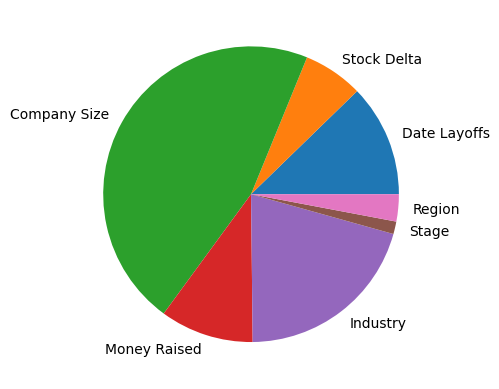

In [31]:
plt.pie(importances, labels=categories)

Figure above shows importance of each feature in prediction

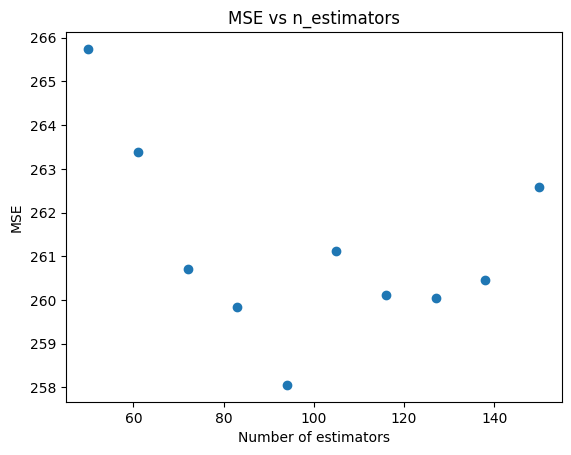

In [44]:
mses_vs_estimators = [x[max_depth.index(bestDepth)][min_samples_split.index(bestSamples)] for x in mses]
plt.scatter(n_estimators, mses_vs_estimators)
plt.xlabel("Number of estimators")
plt.ylabel("MSE")
plt.title("MSE vs n_estimators")
plt.show()

For constant depth and min number of samples, we can plot the MSE vs the number of estimators. Here, we set depth and min number of samples as the best values found by Grid Search. Clearly, we can see that there is an optimal number of estimators at `n_estimators = 94` where the MSE is minimized.